In [ ]:
# import some needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os, json, cv2, random
import sys, shutil, glob
from google.colab.patches import cv2_imshow
from skimage import io  
from datetime import datetime
from distutils.dir_util import copy_tree

### Install Detectron 2

In [ ]:
# This cell only excecutes if you're running on Colab. 
if 'google.colab' in sys.modules:
  from google.colab import drive 
  drive.mount('/gdrive/') # Mount Google Drive! 

  # Clone Audubon bird detection Github repo SP22 branch
  !git clone -b SP22 https://github.com/RiceD2KLab/Audubon_F21.git

  !pip install pyyaml==5.1

  # This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
  !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

  import torch
  TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
  CUDA_VERSION = torch.__version__.split("+")[-1]
  print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
  # Install detectron2 that matches the above pytorch version
  # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
  !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
  # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

  # exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Mounted at /gdrive/
Cloning into 'Audubon_F21'...
remote: Enumerating objects: 1062, done.
remote: Counting objects: 100% (1062/1062), done.
remote: Compressing objects: 100% (638/638), done.
remote: Total 1062 (delta 606), reused 759 (delta 392), pack-reused 0
Receiving objects: 100% (1062/1062), 60.22 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (606/606), done.
     |████████████████████████████████| 274 kB 7.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=824bed803ce5afb24881d4f1ae48798dfebe40b19154f9300dc0cd0c204d0ee9
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 2.9 kB/s 
    

## Load Images

In [ ]:
!mkdir -p './data/raw'

# If downloading a public zip file
!pip install --upgrade --no-cache-dir gdown

!gdown -q https://drive.google.com/uc?id=1zhB6_MLtvD0JCoyKYqhUx497WIvSYVUk
!unzip -q './1017_1.zip' -d './data/raw'
!gdown -q https://drive.google.com/uc?id=1clRsR5zg60FYjQ-crGx8CN88yPsUgVse
!unzip -q './1017_2.zip' -d './data/raw'
!gdown -q https://drive.google.com/uc?id=1fC4xAZJFoEccrgBhvjLMGpzLVXEcfHm6
!unzip -q './annotation_1017.zip' -d './data/raw'

# # If zip files are contained in the mounted Google Drive
# !unzip -q '/gdrive/MyDrive/1017_1.zip' -d './data/raw'
# !unzip -q '/gdrive/MyDrive/1017_2.zip' -d './data/raw'
# !unzip -q '/gdrive/MyDrive/annotation_1017.zip' -d './data/raw'

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=be41de4be1a576fc776c70877d8e84de033fb91f8aa1406a2c27a80e02dc661f
  Stored in directory: /tmp/pip-ephem-wheel-cache-onby48sz/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


### Display an image

In [ ]:
im = cv2.imread("./data/raw/DJI_20210520121129_0616.JPG") 
cv2_imshow(im)

### Show data statistics


 Bird Species Distribution
Mixed Tern Adult                   8641
Laughing Gull Adult                3168
Brown Pelican Adult                 496
Mixed Tern Flying                   156
Other Bird                           95
Laughing Gull Flying                 86
Brown Pelican - Wings Spread         29
Trash/Debris                         23
Great Egret/White Morph Adult        23
Brown Pelican Juvenile               20
Brown Pelican In Flight              17
Brown Pelican Wings Spread           14
Tri-Colored Heron Adult              11
Brown Pelican Chick                   6
Black Crowned Night Heron Adult       1
Roseate Spoonbill Adult               1
Name: class_name, dtype: int64




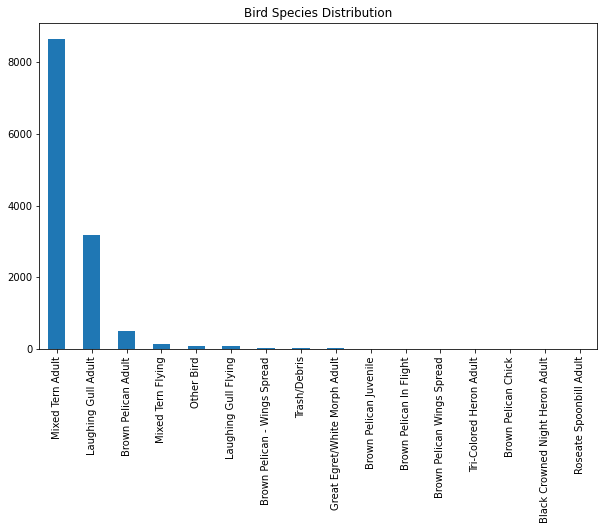

In [ ]:
# This cell plots the distribution of bird species contained in the entire dataset
data_dir = './data/raw' # data directory folder 

# Load CSV files 
target_data = []
for f in glob.glob(os.path.join(data_dir,'*.bbx')): 
  target_data.append(pd.read_csv(f, header=0, 
                              names = ["class_id", "class_name", "x", "y", "width", "height"]) )
target_data = pd.concat(target_data, axis=0, ignore_index=True)

# Create table and bar plot of bird species  
print('\n Bird Species Distribution')
print(target_data["class_name"].value_counts())
print('\n')

ax = target_data["class_name"].value_counts().plot.bar(x="Bird Species", y="Frequency",figsize=(10,6))  
ax.set_title('Bird Species Distribution')
plt.show()

### Plot an image with bounding boxes

In [ ]:
from PIL import Image 
from Audubon_F21.utils import plotting
from Audubon_F21.utils.cropping import csv_to_dict 

annot_dict = csv_to_dict(csv_path = './data/raw/DJI_20210520121129_0616.bbx', annot_file_ext='bbx')
annotation_lst = [list(x.values()) for x in annot_dict['bbox']]

image_file = './data/raw/DJI_20210520121129_0616.JPG'
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
print("Raw image with bounding boxes:")
plotting.plot_img_bbx(image, annotation_lst)

## Crop dataset

In [ ]:
from Audubon_F21.utils.cropping import crop_dataset_trainer

# data_dir is the path that contains both images and annotations (image: jpg; annotation: csv or bbx)
data_dir = './data/raw' # data directory folder 
# output dir is the path where you want to output new files. Please use the folder you defined above.
output_dir = './data/tiled'

crop_dataset_trainer(data_dir, output_dir, annot_file_ext='bbx', crop_height=640, crop_width=640,
                     sliding_size_x=600, sliding_size_y=600, compute_sliding_size=False)

Creating output directory at: ./data/tiled


Cropping files:   0%|          | 0/87 [00:00<?, ?it/s]

## Split dataset into training, validation, and test sets

In [ ]:
 from Audubon_F21.utils.cropping import train_val_test_split

# create a new output folder for train, val, test dataset
# create three folders under the new output folder, with name 'train', 'val', 'test'
!mkdir -p /content/data/split
!mkdir -p /content/data/split/train
!mkdir -p /content/data/split/val
!mkdir -p /content/data/split/test

# specify the folder directory where you have the tiled images (output_dir of the crop_dataset() function)
file_dir = '/content/data/tiled'
# output_dir is the new output folder you created in the cell above
output_dir = '/content/data/split'
# train is a percentage, the fraction of files for training
train_frac = 0.8
# val is a percentage, the fraction of files for validation
val_frac = 0.1
# the fraction for test is default to be 1-train-val
train_val_test_split(file_dir, output_dir, train_frac=train_frac, val_frac=val_frac)

### Show data distribution for each set

In [ ]:
# data directory folders 
data_dir = 'data/split'
dirs = [d for d in os.listdir(data_dir)]

# Load CSV files 
for d in dirs: 
  target_data = []
  for f in glob.glob(os.path.join(data_dir,d,'*.csv')): 
    target_data.append(pd.read_csv(f, header=0, 
                              names = ["class_id", "class_name", "x", "y", "width", "height"]) )
  target_data = pd.concat(target_data, axis=0, ignore_index=True)

  # Visualize dataset 
  print(f'\n {d} - Bird Species Distribution')
  print(target_data["class_name"].value_counts())
  print('\n')


 test - Bird Species Distribution
Mixed Tern Adult                 1076
Laughing Gull Adult               338
Brown Pelican Adult                63
Laughing Gull Flying               12
Mixed Tern Flying                  10
Other Bird                          9
Trash/Debris                        4
Brown Pelican In Flight             2
Brown Pelican - Wings Spread        2
Great Egret/White Morph Adult       1
Brown Pelican Juvenile              1
Name: class_name, dtype: int64



 val - Bird Species Distribution
Mixed Tern Adult                   1073
Laughing Gull Adult                 340
Brown Pelican Adult                  45
Laughing Gull Flying                  9
Mixed Tern Flying                     8
Great Egret/White Morph Adult         5
Other Bird                            5
Brown Pelican Juvenile                4
Brown Pelican - Wings Spread          3
Trash/Debris                          2
Brown Pelican Chick                   1
Brown Pelican Wings Spread            1


# PyTorch

In [ ]:
# import torchvision, torch
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
# # load a model pre-trained pre-trained on COCO and extract only the features
# backbone = torchvision.models.densenet121(pretrained=True).features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For densenet121, it's 1024
# # so we need to add it here
# backbone.out_channels = 1024

# # let's make the RPN generate 3 x 3 anchors per spatial location, with 3 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature map could potentially have different sizes and aspect ratios
# #by default the achor generator FasterRcnn assign will be for a FPN backone, so
# #we need to specify a  different anchor generator
# anchor_generator = AnchorGenerator(sizes=((128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# #here at each position in the grid there will be 3x3=9 anchors
# #and if our backbone is not FPN then the forward method will assign the name '0' to feature map
# #so we need to specify '0' as feature map name
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                  output_size=7,
#                                             sampling_ratio=2)
# # Say we want to classify among 5 birds
# num_classes = 5
# #the output size is the output shape of the roi pooled features which will be used by the box head
# model = FasterRCNN(backbone,num_classes=num_classes,rpn_anchor_generator=anchor_generator)

In [ ]:
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 600)]
# predictions = model(x)


# Detectron2


In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Setup dataloaders 

The following cell registers the training, validation, and testing datasets with Detectron2's dataset catalogs. Note that we register both a version that utilizes both a singular "bird-only" label and the bird species labels. 

**See tutorial for creating a custome dataset.**

In [ ]:
from Audubon_F21.utils.dataloader import register_datasets

data_dir = './data/split'
img_ext='.JPEG'
dirs = [os.path.join(data_dir,d) for d in os.listdir(data_dir)]

# Bird species used by object detector. Species contained in dataset that are 
# not contained in this list will be categorized as an "Unknown Bird"
BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]

# Bounding box colors for bird species (used when plotting images)
BIRD_SPECIES_COLORS = [(255,0,0), (255,153,51), (0, 255, 0), 
                       (0,0,255), (255, 51, 255)]

register_datasets(dirs, img_ext, BIRD_SPECIES, bird_species_colors=BIRD_SPECIES_COLORS)

In [ ]:
# # Example function for getting dictionaries of custom data
# dataset_dicts = get_balloon_dicts("balloon/train")
# for d in random.sample(dataset_dicts, 3):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])

### Test on a pretrained model

In [ ]:
cfg = get_cfg()

model_name = "faster_rcnn_R_50_FPN_1x"   # ResNet-50 FPN backbone

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes) #### instances might not be the correct keyword
print(outputs["instances"].pred_boxes)

In [ ]:
# # We can use `Visualizer` to draw the predictions on the image.
# # Requires metadata registration
# # For instance segmenation with Mask R-CNN, hence may not work exactly for Faster R-CNN
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

## Fine tune a pretrained model

### Prexisting Backbone

In [ ]:
from Audubon_F21.utils.trainer import Trainer

# setup training logger 
setup_logger()

model_name = "faster_rcnn_R_50_FPN_1x"

# Create detectron2 config 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
# Get pretrained model from MS COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_species_train",)
cfg.DATASETS.TEST = ("birds_species_val",)   # val vs test?

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8   # what's a good number for 1 GPU?
cfg.SOLVER.BASE_LR = 1e-3   # pick a good learning rate, 0.00025 is what tutorial uses
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES)
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]   # [] to not decay the learning rate
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train on bird species
trainer = Trainer(cfg)   # DefaultTrainer(cfg) if not using a custom trainer
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

### Custom Backbone

In [ ]:
setup_logger()

cfg = get_cfg()

Model from yaml file

In [ ]:
# load proper yaml config file, then
model = build_model(cfg)

NameError: ignored

Model from config with additional argument overrides

In [ ]:
# Mask R-CNN
model = GeneralizedRCNN(
  cfg,
  roi_heads=StandardROIHeads(cfg, batch_size_per_image=666),
  pixel_std=[57.0, 57.0, 57.0])

Model from full explicit arguments

In [ ]:
# Mask R-CNN
model = GeneralizedRCNN(
    backbone=FPN(
        ResNet(
            BasicStem(3, 64, norm="FrozenBN"),
            ResNet.make_default_stages(50, stride_in_1x1=True, norm="FrozenBN"),
            out_features=["res2", "res3", "res4", "res5"],
        ).freeze(2),
        ["res2", "res3", "res4", "res5"],
        256,
        top_block=LastLevelMaxPool(),
    ),
    proposal_generator=RPN(
        in_features=["p2", "p3", "p4", "p5", "p6"],
        head=StandardRPNHead(in_channels=256, num_anchors=3),
        anchor_generator=DefaultAnchorGenerator(
            sizes=[[32], [64], [128], [256], [512]],
            aspect_ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64],
            offset=0.0,
        ),
        anchor_matcher=Matcher([0.3, 0.7], [0, -1, 1], allow_low_quality_matches=True),
        box2box_transform=Box2BoxTransform([1.0, 1.0, 1.0, 1.0]),
        batch_size_per_image=256,
        positive_fraction=0.5,
        pre_nms_topk=(2000, 1000),
        post_nms_topk=(1000, 1000),
        nms_thresh=0.7,
    ),
    roi_heads=StandardROIHeads(
        num_classes=80,
        batch_size_per_image=512,
        positive_fraction=0.25,
        proposal_matcher=Matcher([0.5], [0, 1], allow_low_quality_matches=False),
        box_in_features=["p2", "p3", "p4", "p5"],
        box_pooler=ROIPooler(7, (1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32), 0, "ROIAlignV2"),
        box_head=FastRCNNConvFCHead(
            ShapeSpec(channels=256, height=7, width=7), conv_dims=[], fc_dims=[1024, 1024]
        ),
        box_predictor=FastRCNNOutputLayers(
            ShapeSpec(channels=1024),
            test_score_thresh=0.05,
            box2box_transform=Box2BoxTransform((10, 10, 5, 5)),
            num_classes=80,
        ),
        mask_in_features=["p2", "p3", "p4", "p5"],
        mask_pooler=ROIPooler(14, (1.0 / 4, 1.0 / 8, 1.0 / 16, 1.0 / 32), 0, "ROIAlignV2"),
        mask_head=MaskRCNNConvUpsampleHead(
            ShapeSpec(channels=256, width=14, height=14),
            num_classes=80,
            conv_dims=[256, 256, 256, 256, 256],
        ),
    ),
    pixel_mean=[103.530, 116.280, 123.675],
    pixel_std=[1.0, 1.0, 1.0],
    input_format="BGR",
)

## From Detectron2

In [ ]:
from detectron2.modeling import BACKBONE_REGISTRY, Backbone, ShapeSpec

In [ ]:
# class ToyBackbone(Backbone):
#   def __init__(self, cfg, input_shape):
#     super().__init__()
#     # create your own backbone
#     self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=16, padding=3)

#   def forward(self, image):
#     return {"conv1": self.conv1(image)}

#   def output_shape(self):
#     return {"conv1": ShapeSpec(channels=64, stride=16)}

In [ ]:
# # class DenseNet(nn.Module):
# class DenseNet(Backbone):
#     r"""Densenet-BC model class, based on
#     `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

#     Args:
#         growth_rate (int) - how many filters to add each layer (`k` in paper)
#         block_config (list of 4 ints) - how many layers in each pooling block
#         num_init_features (int) - the number of filters to learn in the first convolution layer
#         bn_size (int) - multiplicative factor for number of bottle neck layers
#           (i.e. bn_size * k features in the bottleneck layer)
#         drop_rate (float) - dropout rate after each dense layer
#         num_classes (int) - number of classification classes
#         memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
#           but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
#     """

#     def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
#                  num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

#         super(DenseNet, self).__init__()

#         # First convolution
#         self.features = nn.Sequential(OrderedDict([
#             ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
#                                 padding=3, bias=False)),
#             ('norm0', nn.BatchNorm2d(num_init_features)),
#             ('relu0', nn.ReLU(inplace=True)),
#             ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
#         ]))

#         # Each denseblock
#         num_features = num_init_features
#         for i, num_layers in enumerate(block_config):
#             block = _DenseBlock(
#                 num_layers=num_layers,
#                 num_input_features=num_features,
#                 bn_size=bn_size,
#                 growth_rate=growth_rate,
#                 drop_rate=drop_rate,
#                 memory_efficient=memory_efficient
#             )
#             self.features.add_module('denseblock%d' % (i + 1), block)
#             num_features = num_features + num_layers * growth_rate
#             if i != len(block_config) - 1:
#                 trans = _Transition(num_input_features=num_features,
#                                     num_output_features=num_features // 2)
#                 self.features.add_module('transition%d' % (i + 1), trans)
#                 num_features = num_features // 2

#         # Final batch norm
#         self.features.add_module('norm5', nn.BatchNorm2d(num_features))

#         # Linear layer
#         self.classifier = nn.Linear(num_features, num_classes)

#         # Official init from torch repo.
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         features = self.features(x)
#         out = F.relu(features, inplace=True)
#         out = F.adaptive_avg_pool2d(out, (1, 1))
#         out = torch.flatten(out, 1)
#         out = self.classifier(out)
#         return out

#     def output_shape(self):
#         return {"conv1": ShapeSpec(channels=64, stride=16)}

### DenseNet PyTorch Source Code

In [ ]:
from detectron2.modeling import BACKBONE_REGISTRY, Backbone, ShapeSpec, build_model

In [ ]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.hub import load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List


__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']

model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

In [ ]:
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

@BACKBONE_REGISTRY.register()
# class DenseNet(nn.Module):
class DenseNetBackbone(Backbone):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    # class ToyBackbone(Backbone):
    #   def __init__(self, cfg, input_shape):
    #     super().__init__()
    #     # create your own backbone
    #     self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=16, padding=3)

    #   def forward(self, image):
    #     return {"conv1": self.conv1(image)}

    #   def output_shape(self):
    #     return {"conv1": ShapeSpec(channels=64, stride=16)}



    # def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
    #              num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):


    # def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
    #             **kwargs):
    #   model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    #   if pretrained:
    #       _load_state_dict(model, model_urls[arch], progress)
    #   return model

    _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)
    def __init__(self, cgf, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 pretrained = True, arch = 'densenet161', progress=True):

        # super(DenseNet, self).__init__()
        super().__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

        if pretrained:
            _load_state_dict(model, model_urls[arch], progress)
            return model

    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=16, padding=3)

    # def forward(self, image):
    #     return {"conv1": self.conv1(image)}

    def forward(self, x):
        features = self.features(x)
        # out = F.relu(features, inplace=True)
        # out = F.adaptive_avg_pool2d(out, (1, 1))
        # out = torch.flatten(out, 1)
        # out = self.classifier(out)
        # return out
        return features

    def output_shape(self):
        return {"conv1": ShapeSpec(channels=64, stride=16)}


def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained=False, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)



def densenet161(pretrained=False, progress=True, **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress,
                     **kwargs)



def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)



def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)

In [ ]:
setup_logger()
cfg = get_cfg()

model_name = "faster_rcnn_R_50_FPN_1x"

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))

cfg.MODEL.BACKBONE.NAME = 'DenseNetBackbone'   # or set it in the config file

model = build_model(cfg)

TypeError: ignored

In [ ]:

# # setup training logger 
# setup_logger()

# model_name = "faster_rcnn_R_50_FPN_1x"

# # Create detectron2 config 
# cfg = get_cfg()
# # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
# cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
# # Get pretrained model from MS COCO
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_species_train",)
cfg.DATASETS.TEST = ("birds_species_val",)   # val vs test?

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8   # what's a good number for 1 GPU?
cfg.SOLVER.BASE_LR = 1e-3   # pick a good learning rate, 0.00025 is what tutorial uses
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES)
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]   # [] to not decay the learning rate
cfg.SOLVER.CHECKPOINT_PERIOD = 500


In [ ]:
cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

from Audubon_F21.utils.trainer import Trainer
# train on bird species
trainer = Trainer(cfg)   # DefaultTrainer(cfg) if not using a custom trainer
trainer.resume_or_load(resume=False)
trainer.train()

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

We can also evaluate its performance using AP metric implemented in COCO API.

In [ ]:
# From tutorial
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bird_species_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "bird_species_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

Team Audubon Fall 21 created the following functions for performance.

In [ ]:
from detectron2.utils.visualizer import ColorMode
from Audubon_F21.utils.evaluation import plot_precision_recall
from Audubon_F21.utils.evaluation import get_precisions_recalls

print('validation inference:')
val_precisions, val_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_val")
plot_precision_recall(val_precisions, val_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

print('test inference:')
test_precisions, test_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_test")
plot_precision_recall(test_precisions, test_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

# Plot examples of detections on validation and testing tiled images 
for d in ["val", "test"]:
    dataset_dicts = DatasetCatalog.get(f"birds_species_{d}")
    metadata_set = MetadataCatalog.get(f"birds_species_{d}")
    print(f'\n {d} examples:')
    for (i,k) in enumerate(random.sample(dataset_dicts, 2)):   # 2 samples
        im = cv2.imread(k["file_name"])
        outputs = predictor(im)    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        outputs = outputs["instances"].to("cpu")
        outputs = outputs[outputs.scores > 0.5]   # tutorial doesn't remove these; keep line?
        v = Visualizer(im[:, :, ::-1],
                        metadata=metadata_set,
                        scale=0.5,
                        instance_mode=ColorMode.SEGMENTATION)
        out = v.draw_instance_predictions(outputs)
        cv2.imshow(f'{d} prediction {i}',out.get_image()[:, :, ::-1])
        v2_imshow(out.get_image()[:, :, ::-1])

## Run on Test Set

### Tile the test set

The tiling step in the detection pipeline is done using a sliding window. The sub-images are deliberately generated to have a significant proportion of overlapping with adjacent sub-images. We want to have the overlapping to ensure that there is at least one complete version of each bird in one of the sub-images. We then try to eliminate overlapping predicted bounding boxes for the same bird by using non-maximum suppression.

In [ ]:
from Audubon_F21.utils.cropping import crop_dataset_img_only

# create folder to contain tiled images
!rm -rf './data/crop'
!mkdir -p './data/crop'

# perform tiling on images 
# data_dir = './data/raw'   # data directory folder 
data_dir = './data/split/test'
output_dir = './data/crop'
img_ext = '.JPG'
CROP_WIDTH = 640 
CROP_HEIGHT = 640
SLIDING_SIZE = 400 
crop_dataset_img_only(data_dir, img_ext, output_dir, crop_height=CROP_HEIGHT, crop_width=CROP_WIDTH, sliding_size=SLIDING_SIZE)

## Run pipeline

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import evaluate_full_pipeline

# create list of tiled images to be run predictor on 
eval_file_lst = []
eval_file_lst = eval_file_lst + glob.glob('./data/crop/*.JPEG')

# Create detectron2 config and predictor 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model; tutorial uses 0.7

# download model weights
!gdown -q https://drive.google.com/uc?id=1-f_INg5D0yG7AJUkuSJUcIl6BSaf-smR    # currently previous team's weights
# load model weights 
cfg.MODEL.WEIGHTS = "./model_final.pth"   # I'm assuming the downloaded weights were saved as 'model_final.pth'

BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]   # not really used
SPECIES_MAP = {0: 'Brown Pelican', 1: 'Laughing Gull', 2: 'Mixed Tern', 3: 'Great Blue Heron',
               4: 'Great Egret/White Morph', 5: 'Other/Unknown'}

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES) 

# Create default predictor to run inference 
predictor = DefaultPredictor(cfg)
RAW_IMG_WIDTH = 8192
RAW_IMG_HEIGHT = 5460

# Run evaluation 
output_df = evaluate_full_pipeline(eval_file_lst, predictor, SPECIES_MAP, RAW_IMG_WIDTH, RAW_IMG_HEIGHT,
                           CROP_WIDTH, CROP_HEIGHT, SLIDING_SIZE)

## Download annotations as CSV file

In [ ]:
from google.colab import files
output_df.to_csv('output.csv')
files.download('output.csv')